In [1]:
import sys
sys.path.append('D:/Python/Projecten/pypv/lib')  # add my own lib folder to Python's search path
sys.path.append('D:/Python/Projecten/pypv/datafiles')  # add the folder with the py-script for the horizon profiles

In [2]:
from IPython.display import HTML
import sun
import photovoltaic as pv
from quantities.date_time import Date, ANY_YEAR

# 1. PV SYSTEM DESIGN

## 1.1 Set Up Geographic Location and Horizon Profiles

In [3]:
loc = sun.Location(
    name='Ghent',
    region='Belgium',
    latitude=51.07,
    longitude=3.69,
    altitude=9.0
)

**Import horizon profiles from Python script 'horizon_profiles.py'**

In [4]:
from horizon_profiles import hp_01, hp_02

**Plot sun path diagrams with horizon profile 'hp_01' (front of flat roof)**

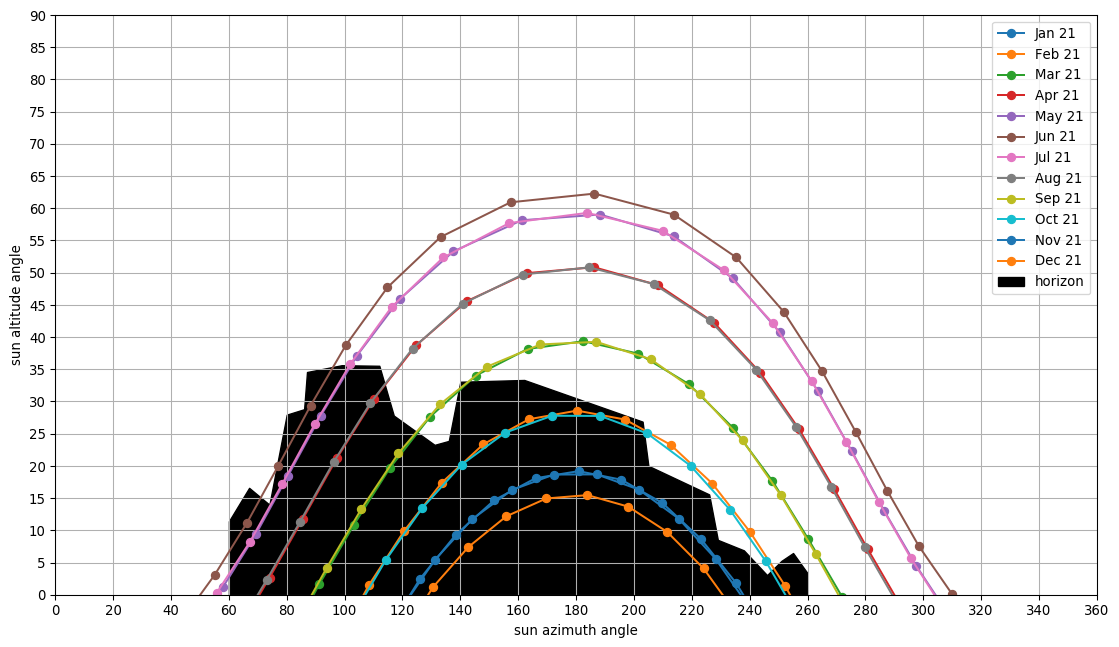

In [5]:
spl = [sun.SunPath(loc, Date(ANY_YEAR, m, 21)) for m in range(1, 13)]
p = sun.plot_sun_path_diagram(spl, hp_01, size=(14, 8), dpi=96)
p.show_graph()

**Plot sun path diagram with horizon profile 'hp_02' (at the end of the flat roof)**

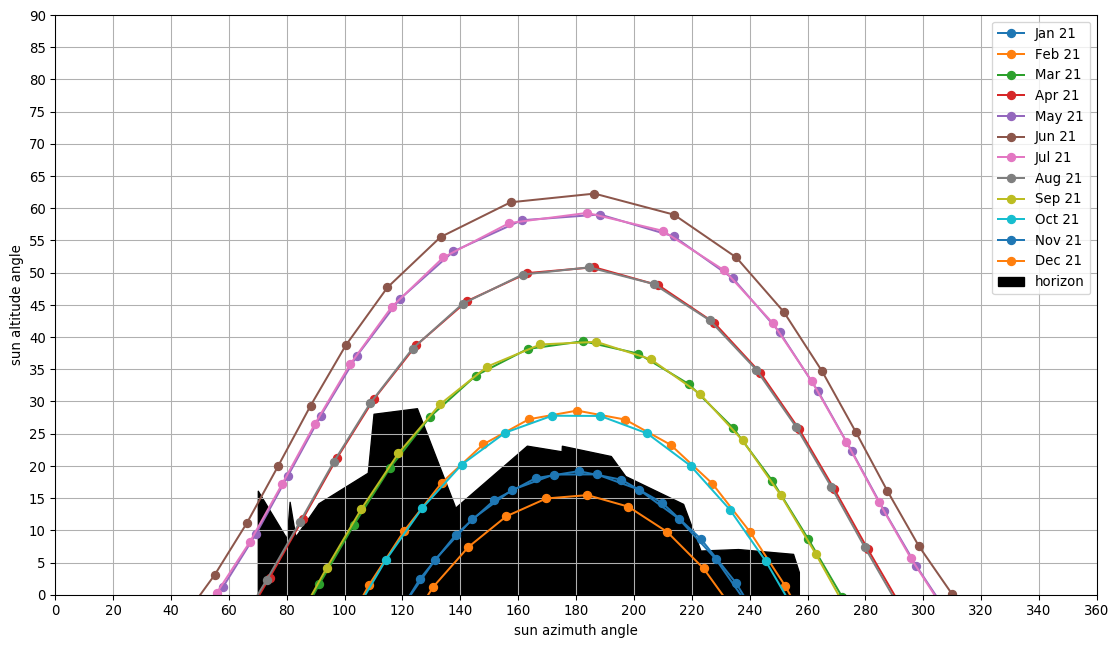

In [6]:
p = sun.plot_sun_path_diagram(spl, hp_02, size=(14, 8), dpi=96)
p.show_graph()

## 1.2 Set Up PV Matrices

### Solar Panels

**Photovoltaic specifications of solar panels**

In [7]:
pv_char = pv.PhotoVoltaicCharacteristics(
    pv.STC(Isc=9.97, Voc=39.4, Impp=9.63, Vmpp=31.2),
    pv.TemperatureCoefficients(cIsc=0.05, cVoc=-0.29, cPmpp=-0.4),
    noct=48.0
)

**Solar panel with eastern orientation**

In [8]:
solar_panel_east_hp01 = pv.SolarPanel(
    loc=loc,
    orient=pv.Orientation(azimuth=78.0, tilt=20.0),
    dim=pv.Dimensions(width=0.99, height=1.66),
    pv_char=pv_char,
    hz_profile=hp_01
)

In [9]:
solar_panel_east_hp02 = pv.SolarPanel(
    loc=loc,
    orient=pv.Orientation(azimuth=78.0, tilt=20.0),
    dim=pv.Dimensions(width=0.99, height=1.66),
    pv_char=pv_char,
    hz_profile=hp_02
)

**Solar panel with western orientation**

In [10]:
solar_panel_west_hp01 = pv.SolarPanel(
    loc=loc,
    orient=pv.Orientation(azimuth=258.0, tilt=20.0),
    dim=pv.Dimensions(width=0.99, height=1.66),
    pv_char=pv_char,
    hz_profile=hp_01
)

In [11]:
solar_panel_west_hp02 = pv.SolarPanel(
    loc=loc,
    orient=pv.Orientation(azimuth=258.0, tilt=20.0),
    dim=pv.Dimensions(width=0.99, height=1.66),
    pv_char=pv_char,
    hz_profile=hp_02
)

### Solar Panel Matrices

**PV matrix 1 with eastern orientation**

In [12]:
row_num = 9  # number of solar panels in one string
col_num = 1  # number of strings

pv_matrix_east = pv.SolarPanelMatrix('PVM-east', row_num=row_num, col_num=col_num)
for r in range(row_num):
    for c in range(col_num):
        if 0 <= r < 5:
            pv_matrix_east.add_solar_panel(solar_panel_east_hp01, r, c)
        if 5 <= r < 9:
            pv_matrix_east.add_solar_panel(solar_panel_east_hp02, r, c)

**PV matrix 2 with western orientation**

In [13]:
row_num = 9
col_num = 1

pv_matrix_west = pv.SolarPanelMatrix('PVM-west', row_num=row_num, col_num=col_num)
for r in range(row_num):
    for c in range(col_num):
        if 0 <= r < 5:
            pv_matrix_west.add_solar_panel(solar_panel_west_hp01, r, c)
        if 5 <= r < 9:
            pv_matrix_west.add_solar_panel(solar_panel_west_hp02, r, c)

**PV matrix performance at STC**

In [14]:
for pv_matrix in (pv_matrix_east, pv_matrix_west):
    display(HTML(f'<b>Performance of PV matrix {pv_matrix.id} at STC</b>'))
    pv_matrix.set_operating_conditions(Gsurf=1000.0, Tcell=25.0)  # STC conditions
    display(HTML(f'- peak power = <b>{pv_matrix.get_mpp_power() / 1000.0:.1f}</b> kWp'))
    display(HTML(f'- MPP current = <b>{pv_matrix.get_mpp_current():.1f}</b> A'))
    display(HTML(f'- MPP voltage = <b>{pv_matrix.get_mpp_voltage():.1f}</b> V'))
    display(HTML(f'- short circuit current = <b>{pv_matrix.get_sc_current():.1f}</b> A'))
    display(HTML(f'- open circuit voltage = <b>{pv_matrix.get_oc_voltage():.1f}</b> V'))

**Required cross section of string cables**

In [15]:
for pv_matrix in (pv_matrix_east, pv_matrix_west):
    pv_matrix.string_cables.set_cable_lengths(25)
    cs_min = pv_matrix.string_cables.calc_min_cross_sections()
    display(HTML(f'min. required string cable cross section {pv_matrix.id} = <b>{cs_min[0]:.1f}</b> mm²'))

## 1.3 Set Up PV Inverters

**Add PV matrices to inverter**

In [16]:
pv_inverter = pv.Inverter('INVERTER')
for pv_matrix in (pv_matrix_east, pv_matrix_west):
    pv_inverter.add_pv_matrix(pv_matrix)

**Inverter working range requirements**

In [17]:
inv_req = pv_inverter.get_requirements()
display(HTML(
    f"- Minimum value of nominal AC power: <b>{inv_req['Pac_min'][0] / 1000.0:.3f}</b> kW<br>"
    f"- Maximum value of nominal AC power: <b>{inv_req['Pac_max'][0] / 1000.0:.3f}</b> kW<br>"
    f"- Minimum value of maximum DC voltage: <b>{inv_req['Vdc_max'][0]:.3f}</b> V<br>"
    f"- Maximum value of minimum MPP voltage: <b>{inv_req['Vmpp_min'][0]:.3f}</b> V<br>"
    f"- Minimum value of maximum DC current: <b>{inv_req['Idc_max'][0]:.3f}</b> A<br>"
    f"- Minimum value of maximum DC power: <b>{inv_req['Pdc_max'][0] / 1000.0:.3f}</b> kW."
))

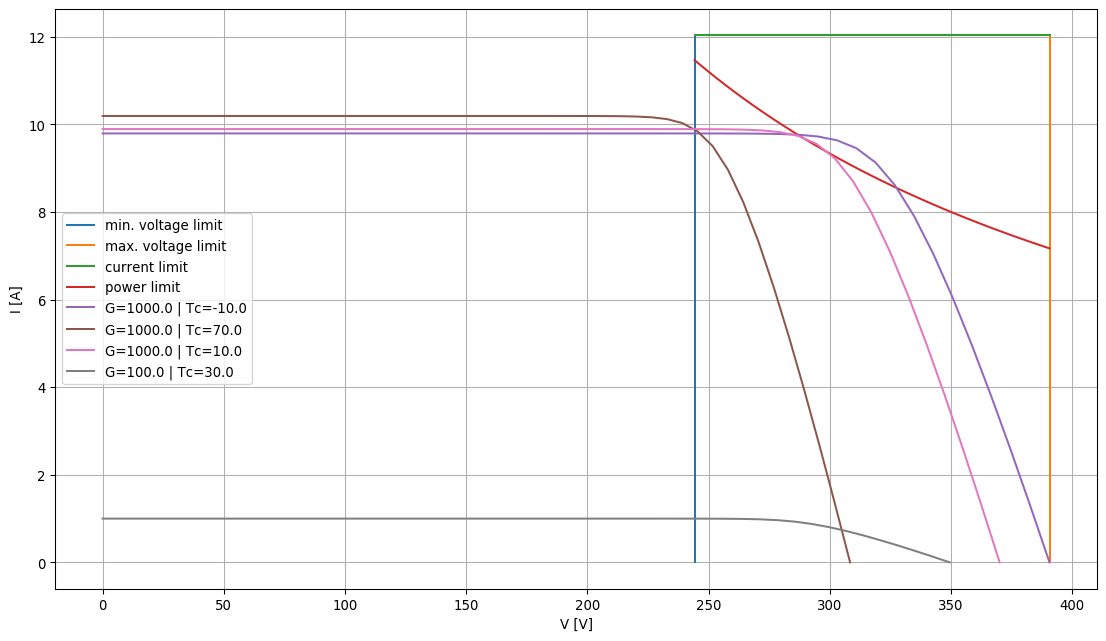

In [18]:
graph = pv_inverter.plot_working_range(required_range=True, fig_size=(14, 8), dpi=96)
graph.show_graph()

# 2. SIZING PV SYSTEM

## 2.1 Sizing String Cables

In [19]:
pv_matrix_east.string_cables.set_cross_sections(4.0)
pv_matrix_west.string_cables.set_cross_sections(4.0)

## 2.2 PV Inverter Selection

**SMA Sunny Boy 5.0 (SB5.0-1AV-40)**

In [20]:
pv_inverter.setup(
    Pac_nom=5000.0,
    Vdc_nom=365.0,
    Vdc_max=600.0,
    Vmpp_min=175.0,
    Vmpp_max=500.0,
    Idc_max=15.0,
    Pdc_max=7500.0,
    eff_max=97.0
)

**Inverter efficiencies**

In [21]:
pv_inverter.set_part_load_efficiencies(
    eff_at_Vmpp_min={5: 91.2, 10: 93.8, 20: 95.3, 25: 95.5, 30: 95.6, 50: 95.6, 75: 95.2, 100: 94.6},
    eff_at_Vdc_nom={5: 92.5, 10: 95.2, 20: 96.6, 25: 96.8, 30: 97.0, 50: 97.0, 75: 96.7, 100: 96.2},
    eff_at_Vmpp_max={5: 90.7, 10: 94.4, 20: 96.2, 25: 96.5, 30: 96.6, 50: 96.8, 75: 96.5, 100: 96.1}
)

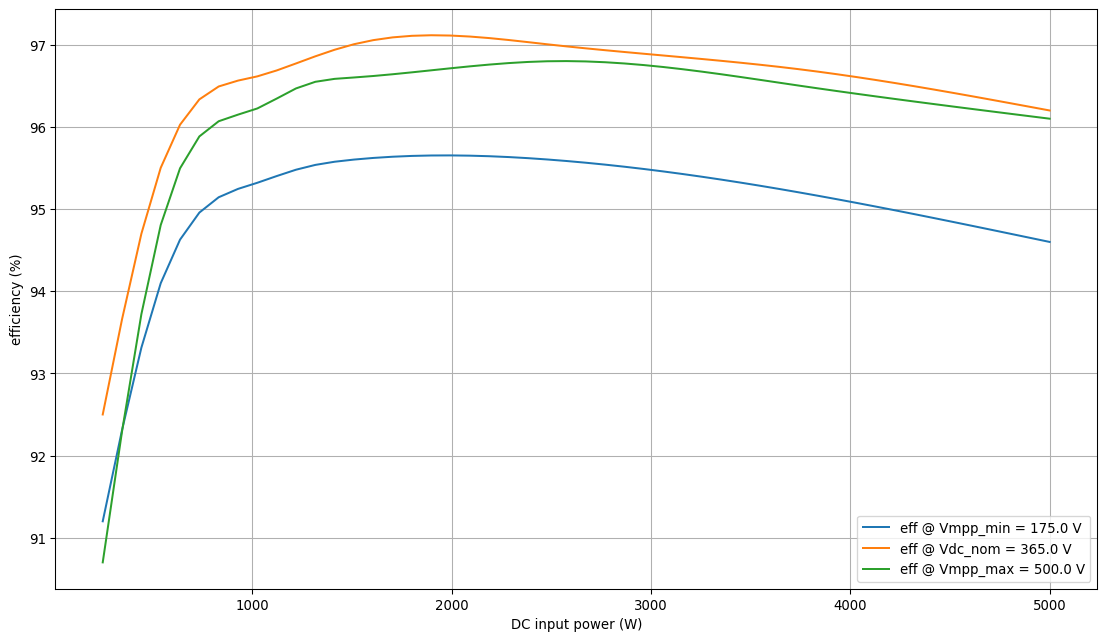

In [22]:
graph = pv_inverter.plot_efficiency_curves(fig_size=(14, 8), dpi=96)

**Check selected inverter with working range requirements**

In [23]:
results = pv_inverter.check()
msg = ''
if results:
    for result in results:
        msg = result + '<br>'
else:
    msg = 'All inverter requirements are fulfilled!'
display(HTML(msg))

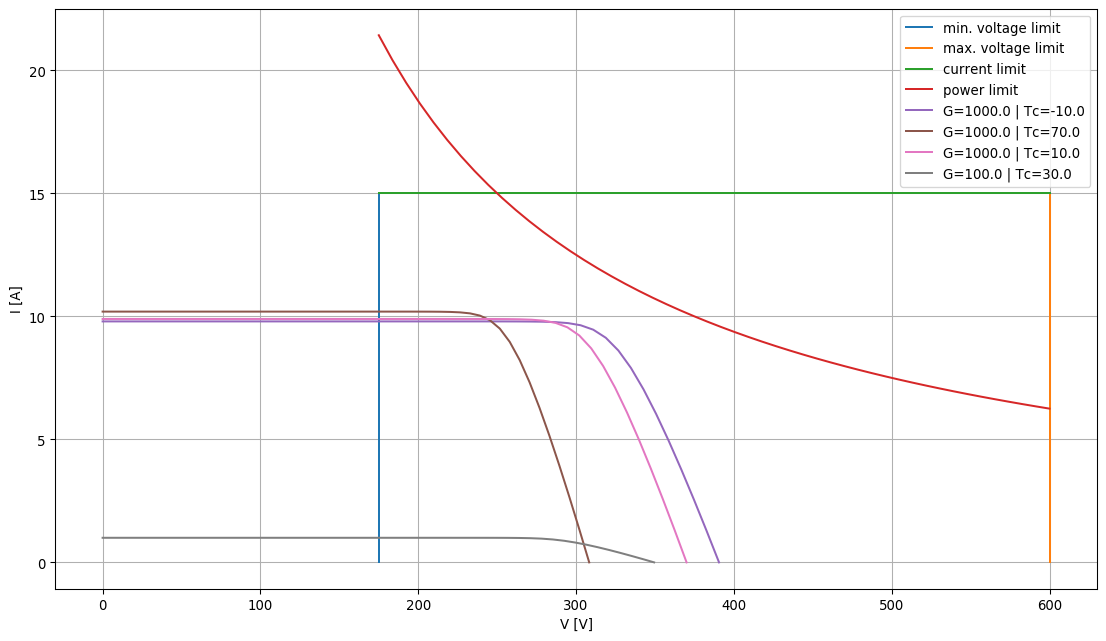

In [24]:
graph = pv_inverter.plot_working_range(fig_size=(14, 8), dpi=96)
graph.show_graph()

# 3. ENERGY ANALYSIS

In [25]:
ea = pv.EnergyAnalyzer(
    TMY_file='../datafiles/tmy.csv',
    CLP_file='../datafiles/mlp.csv',
    location=loc,
    pv_inverters=[pv_inverter]
)
%time ea.analyze()

Wall time: 4min 29s


## 3.1 Yield and Load Profiles

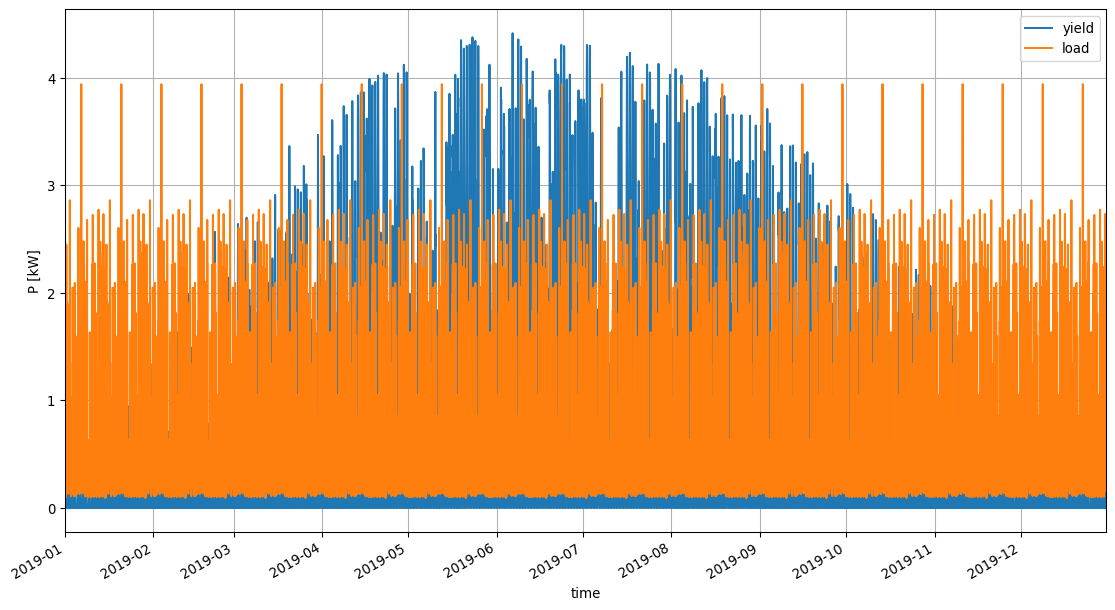

In [26]:
graph = ea.plot_profiles(fig_size=(14, 8), dpi=96)
graph.show_graph()

### Annual Yield and Consumption

In [27]:
display(HTML(f'Annual yield = <b>{ea.get_annual_yield():.0f}</b> kWh'))

In [28]:
display(HTML(f'Annual load = <b>{ea.get_annual_load():.0f}</b> kWh'))

## 3.1 Energy Flows in PV System Without Battery Storage System

### Overview Monthly Energy Flows

- energy flow from grid to load (Egtl, kWh) = grid supply
- energy flow from PV system to grid (Eptg, kWh) = grid injection
- energy flow from PV system to load (Eptl, kWh)
- energy flow from PV system to battery (Eptb, kWh)
- energy flow from battery to load (Ebtl, kWh)

In [29]:
display(HTML(ea.get_monthly_overview().to_html()))

,Egtl,Eptg,Eptl,Eptb,Ebtl
1,256.093581,33.843208,61.673482,0.0,0.0
2,199.551792,95.925242,86.366115,0.0,0.0
3,191.709604,279.079706,123.139329,0.0,0.0
4,155.748527,609.438008,148.139749,0.0,0.0
5,143.954194,611.026784,164.444962,0.0,0.0
6,138.822504,739.922093,168.512696,0.0,0.0
7,151.134437,650.715979,167.320621,0.0,0.0
8,154.354535,631.108177,156.410200,0.0,0.0
9,174.209156,400.303215,134.261764,0.0,0.0
10,206.840878,194.051593,106.741623,0.0,0.0


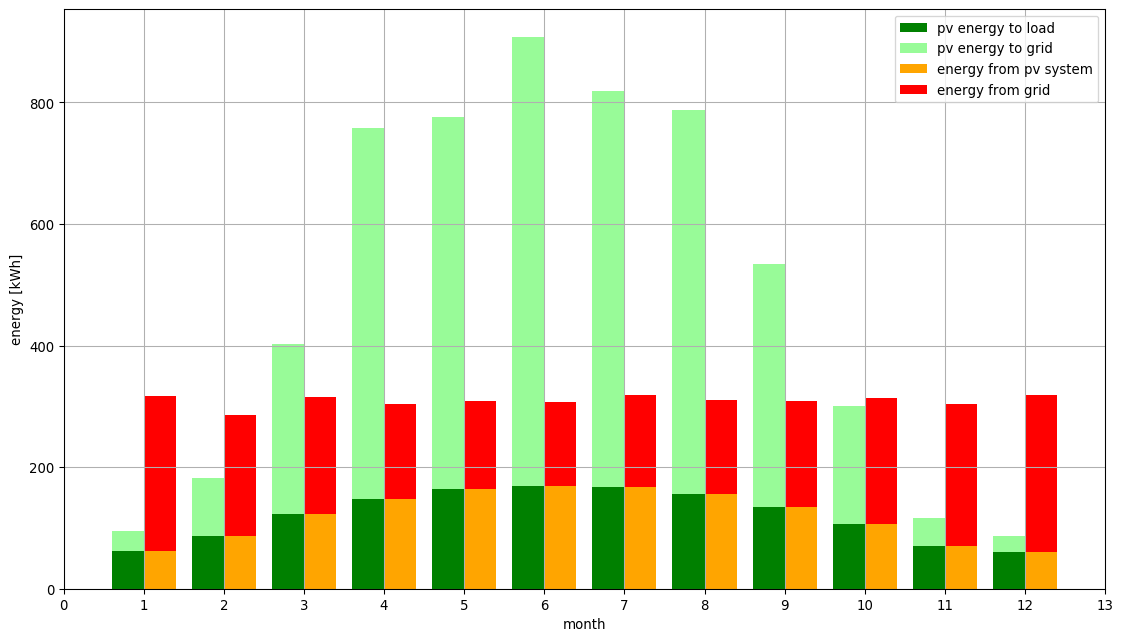

In [30]:
graph = ea.plot_monthly_overview(fig_size=(14, 8), dpi=96)

### Self Sufficiency and Self Consumption

In [31]:
display(HTML(f'Self-sufficiency (i.e. percentage of annual consumption delivered by PV-system) = <b>{ea.get_self_sufficiency():.2f}</b> %'))

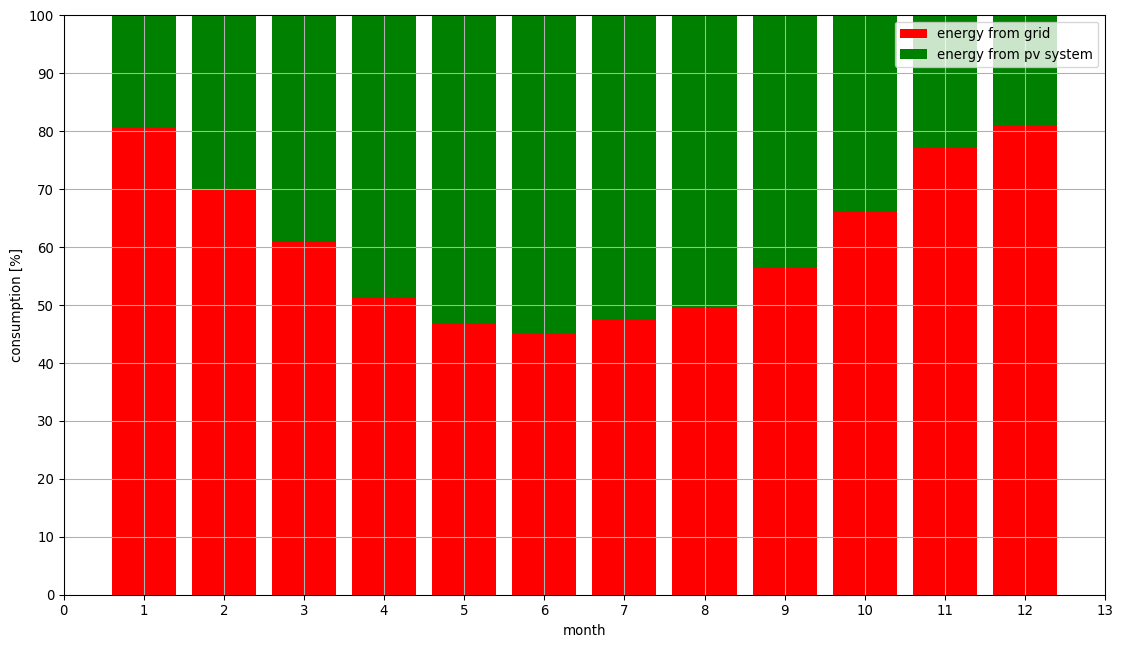

In [32]:
graph = ea.plot_self_sufficiency(fig_size=(14, 8), dpi=96)
graph.show_graph()

In [33]:
display(HTML(f'Self-consumption (i.e. percentage of annual yield consumed by own loads) = <b>{ea.get_self_consumption():.2f}</b> %'))

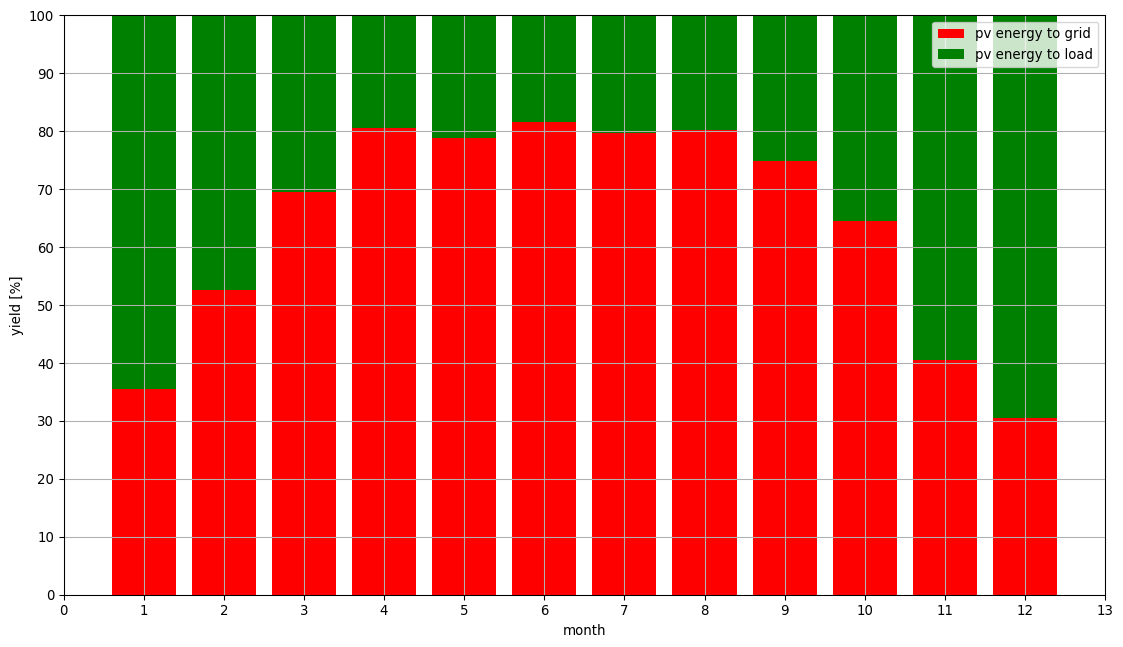

In [34]:
graph = ea.plot_self_consumption(fig_size=(14, 8), dpi=96)
graph.show_graph()

### Net Consumption From Grid

Net consumption is the difference between energy taken from the grid and energy injected into the grid by the PV system.

In [35]:
display(HTML(f'Net consumption from grid = <b>{ea.get_net_consumption():.0f}</b> kWh'))

## 3.2 Energy Flows In PV System With Battery Storage System

### Set Up Battery

In [36]:
ea.battery = pv.Battery(battery_capacity=3 * 1.676)          # available battery capacity depending on load and unload current (see battery specs)
ea.battery.set_loading_params(Idc=10.0, Vdc=56.0, eff=0.9)   # battery current, load voltage and efficiency when loading
ea.battery.set_unloading_params(Idc=15.0, Vdc=48.0, eff=0.9) # battery current, load voltage and efficiency when unloading

### Overview Monthly Energy Flows

In [37]:
Eflow_stats = ea.analyze_energy_flows()
display(HTML(ea.get_monthly_overview().to_html()))

,Egtl,Eptg,Eptl,Eptb,Ebtl
1,222.250373,0.000000,61.673482,33.843208,33.843208
2,118.892719,15.266169,86.366115,80.659074,80.659074
3,44.244112,131.614214,123.139329,147.465492,147.465492
4,17.469874,471.159355,148.139749,138.278653,138.278653
5,10.631851,475.510714,164.444962,135.516070,133.322343
6,6.655389,608.104506,168.512696,131.817586,132.167116
7,12.654222,514.079960,167.320621,136.636019,138.480216
8,14.122640,490.876282,156.410200,140.231895,140.231895
9,32.167461,258.261520,134.261764,142.041695,142.041695
10,90.191650,77.402365,106.741623,116.649228,116.649228


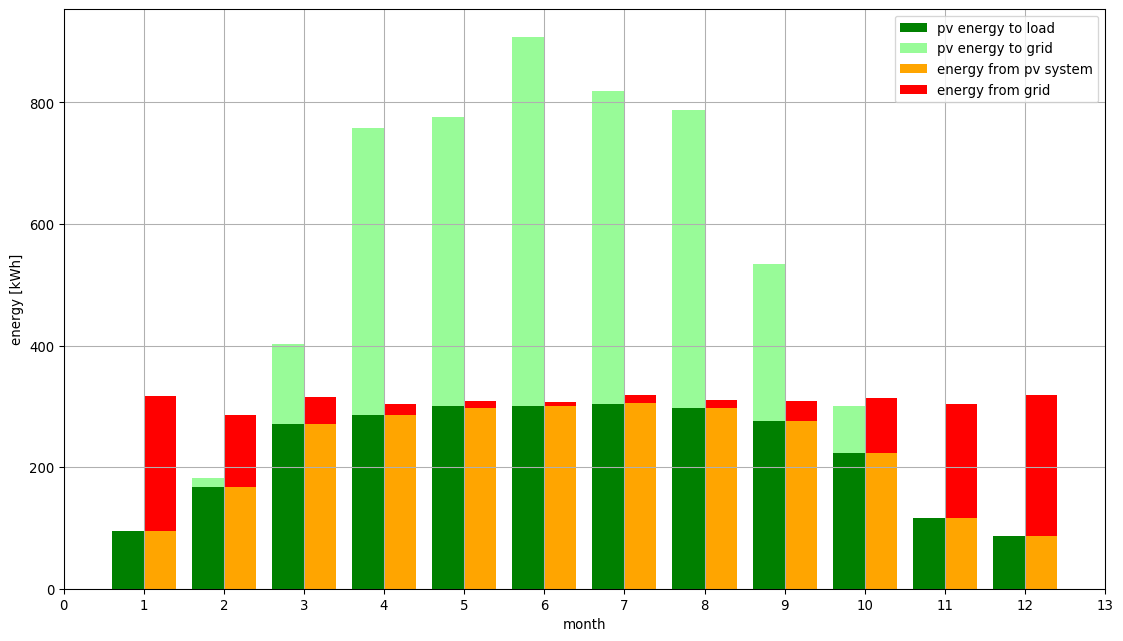

In [38]:
graph = ea.plot_monthly_overview(fig_size=(14, 8), dpi=96)
graph.show_graph()

### Self Sufficiency and Self Consumption

In [39]:
display(HTML(f'Self-sufficiency (i.e. percentage of annual consumption delivered by PV-system) = <b>{ea.get_self_sufficiency():.2f}</b> %'))

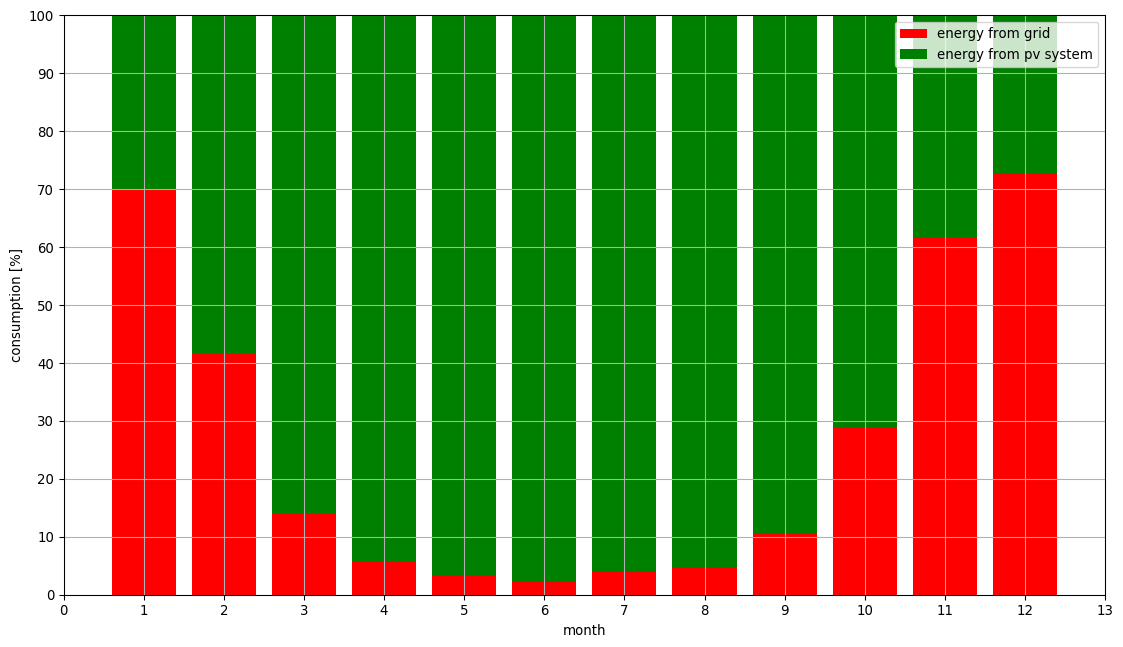

In [40]:
graph = ea.plot_self_sufficiency(fig_size=(14, 8), dpi=96)
graph.show_graph()

In [41]:
display(HTML(f'Self-consumption (i.e. percentage of annual yield consumed by own loads) = <b>{ea.get_self_consumption():.2f}</b> %'))

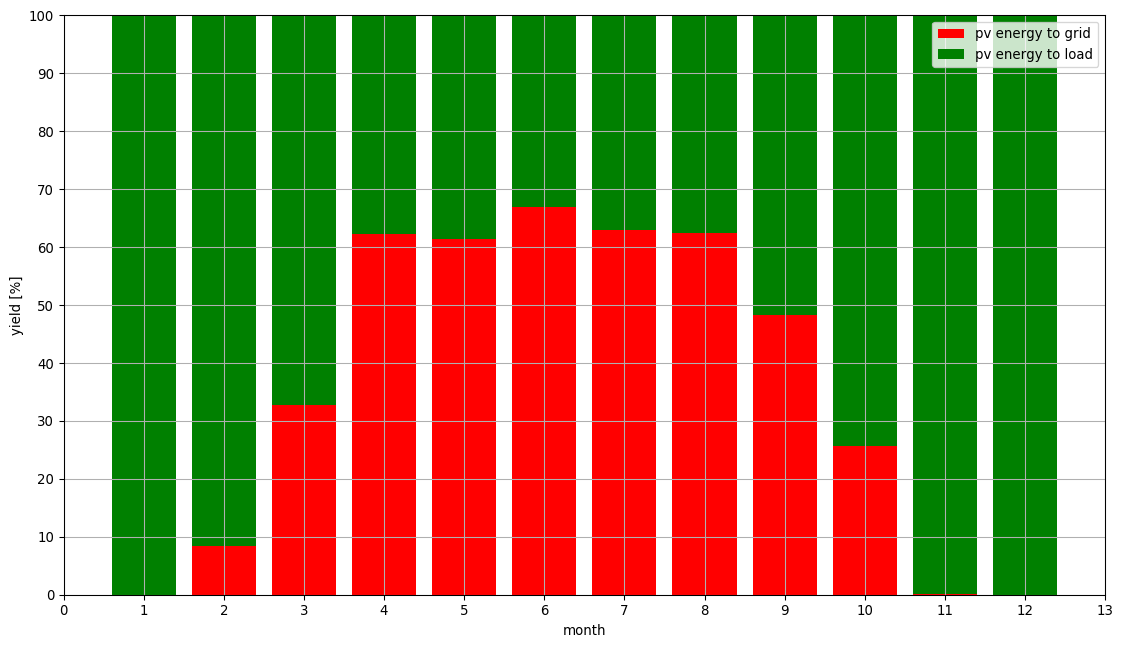

In [42]:
graph = ea.plot_self_consumption(fig_size=(14, 8), dpi=96)
graph.show_graph()

**Self sufficiency as function of battery capacity**

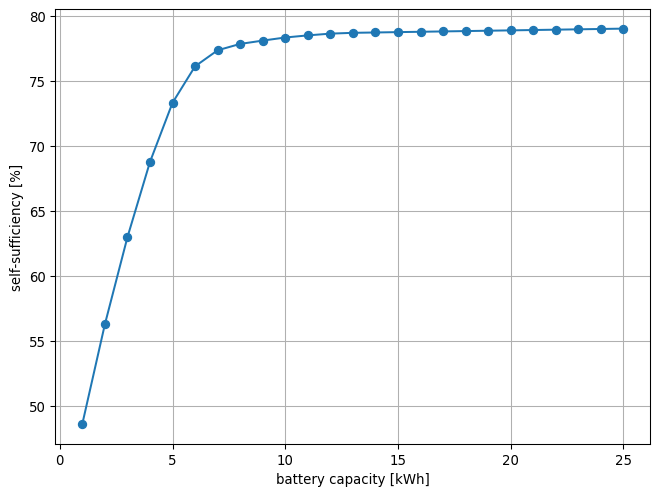

In [43]:
from nummath import graphing

battery_capacities = [i for i in range(1, 26)]
self_sufficiency = []
for battery_capacity in battery_capacities:
    ea.battery = pv.Battery(battery_capacity)
    ea.analyze_energy_flows()
    self_sufficiency.append(ea.get_self_sufficiency())

graph = graphing.Graph(fig_size=(8, 6), dpi=96)
graph.add_data_set(name='none', x=battery_capacities, y=self_sufficiency, marker='o')
graph.set_axis_titles(x_title='battery capacity [kWh]', y_title='self-sufficiency [%]')
graph.turn_grid_on()
graph.draw_graph()
graph.show_graph()

### Net Consumption From Grid

In [44]:
display(HTML(f'Net consumption from grid = <b>{ea.get_net_consumption():.0f}</b> kWh'))